In [103]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Getting Dataframes

In [104]:
master_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
data = master_data
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [105]:
master_submit = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
submit = master_submit
submit.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Data Wrangling

In [106]:
#pd.set_option('display.max_rows',5)
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 81 entries, Id to SalePrice
dtypes: float64(3), int64(35), object(43)
memory usage: 924.0+ KB


In [107]:
data.shape

(1460, 81)

In [108]:
submit.shape

(1459, 80)

In [109]:
#data.info(verbose=True)

In [110]:
#pd.set_option('display.max_rows',None)
#data.isna().sum()

In [111]:
#data['MiscVal'].unique()

In [112]:
#data[['MiscFeature','MiscVal']]

In [113]:
data = data.drop(['MiscFeature'], axis=1)
submit = submit.drop(['MiscFeature'], axis=1)

In [114]:
print("shape of given data", data.shape)
print("shape of submit data", submit.shape)

shape of given data (1460, 80)
shape of submit data (1459, 79)


# Feature Engineering

## Separating independent and dependent variables

In [115]:
X_data=data
X_data=X_data.drop(['SalePrice'], axis=1)
X_submit=submit
#X_data.head()

In [116]:
Y_data=data['SalePrice']
Y_data.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

## One hot encoding

In [117]:
print("shape before one hot encoding", X_data.shape)
X_data=pd.get_dummies(X_data)

dummies_frame = pd.get_dummies(X_data)
X_submit=X_submit.reindex(columns = dummies_frame.columns, fill_value=0)
#X_test=pd.get_dummies(X_test)

print("shape after one hot encoding", X_data.shape)
X_data.head()

shape before one hot encoding (1460, 79)
shape after one hot encoding (1460, 285)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0


In [118]:
X_data=X_data.fillna(0)
X_submit=X_submit.fillna(0)
#X.isna().sum()

In [119]:
print("shape of X_data", X_data.shape)
print("shape of X_submit", X_submit.shape)

shape of X_data (1460, 285)
shape of X_submit (1459, 285)


## Data Scaling

In [120]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled_data = scaler.fit_transform(X_data)
X_scaled_submit = scaler.transform(X_submit)
X_scaled_data

array([[-1.73086488,  0.07337496,  0.2128772 , ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.7284922 , -0.87256276,  0.64574726, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.72611953,  0.07337496,  0.29945121, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ...,
       [ 1.72611953,  0.30985939,  0.2417352 , ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 1.7284922 , -0.87256276,  0.29945121, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 1.73086488, -0.87256276,  0.50145724, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [121]:
print("Memory size of numpy array in bytes:", X_scaled_data.size * X_scaled_data.itemsize)

Memory size of numpy array in bytes: 3328800


In [122]:
X_scaled_data.dtype

dtype('float64')

In [123]:
X_scaled_data.size

416100

In [124]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

f16=np.float16(X_scaled_data)
#f16=trunc(f16, decs=2)
print("Memory size of numpy array in bytes:", f16.size * f16.itemsize)
f16

Memory size of numpy array in bytes: 832200


array([[-1.73   ,  0.07336,  0.2129 , ..., -0.11786,  0.4678 , -0.306  ],
       [-1.729  , -0.8726 ,  0.6455 , ..., -0.11786,  0.4678 , -0.306  ],
       [-1.727  ,  0.07336,  0.2996 , ..., -0.11786,  0.4678 , -0.306  ],
       ...,
       [ 1.727  ,  0.3098 ,  0.2417 , ..., -0.11786,  0.4678 , -0.306  ],
       [ 1.729  , -0.8726 ,  0.2996 , ..., -0.11786,  0.4678 , -0.306  ],
       [ 1.73   , -0.8726 ,  0.5015 , ..., -0.11786,  0.4678 , -0.306  ]],
      dtype=float16)

In [125]:
#X_scaled_data=f16

In [126]:
np.any(np.isnan(X_scaled_data))

False

## Train Test split

In [127]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled_data, Y_data, test_size=0.33, random_state=42)

print("shape of training data", X_train.shape)
print("shape of testing data", X_test.shape)

shape of training data (978, 285)
shape of testing data (482, 285)


# Linear/Polynomial Regression

iteration =  1
Memory size of numpy array in bytes in MB: 2.237664
iteration =  2
Memory size of numpy array in bytes in MB: 321.104784
[-6.737439346450269e+23, 0.8010567171150325]


<function matplotlib.pyplot.show(close=None, block=None)>

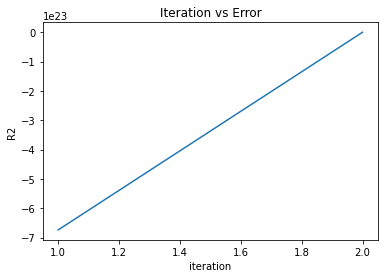

In [128]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

errors=[]

sweep = np.arange(1, 3, 1, dtype=int)
for i in sweep:
    print("iteration = ", i)
    poly = PolynomialFeatures(degree = i)
    
    X_poly_train = poly.fit_transform(X_train)
    X_poly_test = poly.transform(X_test)
    print("Memory size of numpy array in bytes in MB:", X_poly_train.size * X_poly_train.itemsize / 1000000)
    
    reg = LinearRegression()
    reg.fit(X_poly_train, Y_train)
    
    errors.append(reg.score(X_poly_test, Y_test))
    
print(errors)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(sweep, errors)
plt.xlabel("iteration")
plt.ylabel("R2")
plt.title("Iteration vs Error")
plt.show

## Ridge Regression

In [129]:
alphas = 10**np.linspace(10,-2,100)*0.5
print(len(alphas))
#alphas = [0.1, 1, 10, 100]
#alphas

100


In [130]:
poly = PolynomialFeatures(degree = 2)
    
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

In [131]:
from sklearn.linear_model import Ridge
from tqdm import tqdm

#f = IntProgress(min=0, max=len(alphas)) # instantiate the bar
#display(f)

errors=[]
sweep = np.arange(1, len(alphas), 1, dtype=int)
for i in tqdm(range(0, len(alphas)-1)):
    #print(i)
    #f.value += 1
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_poly_train, Y_train)
    errors.append(reg.score(X_poly_test, Y_test))

print(errors)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(sweep, errors)
plt.xlabel("iteration")
plt.ylabel("R2")
plt.title("Iteration vs Error")
plt.show

 66%|██████▌   | 65/99 [01:19<00:41,  1.22s/it]


KeyboardInterrupt: 

In [ ]:
max(errors)

## Polynomial regression with PCA for higher dgrees

In [132]:
from sklearn.decomposition import PCA

pca = PCA(0.90)
X_scaled_pca_data = pca.fit_transform(X_scaled_data)
X_scaled_pca_data.shape

print("shape without pca", X_scaled_data.shape)
print("shape without pca", X_scaled_pca_data.shape)

shape without pca (1460, 285)
shape without pca (1460, 154)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled_pca, Y_data, test_size=0.33, random_state=42)

print("shape of training data", X_train.shape)
print("shape of testing data", X_test.shape)

## PCA train test split

## Submission for polynomial regression

In [98]:
X_scaled_poly_submit = poly.transform(X_scaled_submit)
predictions = reg.predict(X_scaled_poly_submit)
print(predictions)

[199437.22171287 204608.93926633 136595.15954564 ... 136973.65711095
 193566.87251257 102677.56688362]


In [99]:
X_submit['SalePrice']=predictions
#X_test.head()

In [100]:
submitdf = X_submit[['Id','SalePrice']].set_index('Id')
submitdf.head()

,SalePrice
Id,
1461,199437.221713
1462,204608.939266
1463,136595.159546
1464,131268.117204
1465,159312.051204


In [101]:
!cd /kaggle/workingcd input
submitdf.to_csv("submission.csv")
!head submission.csv

/bin/bash: line 0: cd: too many arguments
Id,SalePrice
1461,199437.22171286814
1462,204608.93926632832
1463,136595.15954564413
1464,131268.11720415644
1465,159312.05120418395
1466,143608.52513592498
1467,152015.60028762382
1468,148265.273234095
1469,144637.94403722085
